In [1]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib, tarfile, shutil, os, glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from sklearn.cluster import KMeans


%matplotlib inline
from IPython.display import HTML
HTML('''<script> code_show=true; 
function code_toggle() {
if (code_show){$('div.input').hide();}
else {$('div.input').show();}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script> To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')                             


# Statistical Anomaly Detection
Clustering technqniques, like K-Means and DBSCAN, do not work because they are good at learning things they have already seen. Since there is not a finite set of superbasin access regimes, this will not work (*e.g.*, detecting cats from a set of animals). Here we try statistical modeling to detect access regimes.

In [2]:
font = {'size'   : 12}

matplotlib.rc('font', **font)

names = {"0": "Splicer", "1": "Worker", "2": "PersistentDB",
         "3": "InMemoryDB", "4": "WorkManager", -1: "all ranks"}

def untar(fname):
    try: shutil.rmtree("tmp")
    except: pass
    os.mkdir("tmp")
    tar = tarfile.open(fname)
    tar.extractall()
    tar.close()
d = "../results/"
def plot_times(ax, label, results):
    #colors = ['#8c510a', '#d8b365', '#f6e8c3', '#c7eae5', '#5ab4ac', '#01665e']
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    ax.plot(df["wc"], df["traj"], label=label, lw=2)
    ax.set_ylabel("Trajectory Length (pico seconds)")
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax.legend()
### Boring Parsing Info
# The data structure we read into is a dictionary, where the key is a tuple that identifies the job and the 
# value is a tuple with parsed data in Python data frames. The `parse()` function reads the raw data and 
# puts it into the dictionary:
#
# dfs[(name, op, rank)] => {KEY TIMES, KEY COUNT}
#
# where `name` is a human readable string that describes the job, `op` is the type of database operation,
# `rank` is the MPI rank number, `KEY TIMES` has keys and timestamps, and `KEY COUNT` has keys and counts (i.e. # 
# of occurences). We save `countDF` because it takes forever to parse this data.
def parse(dfs, name, results):
    stats = []
    for rank in ["0", "1", "2", "3", "4"]:
        untar(results + "/out/semanticPerf." + rank + ".tar.gz")
        shutil.move("semanticPerf." + rank, "tmp/semanticPerf." + rank)
        for op in ["DBMemoryPut", "DBMemoryGet"]:
            os.system("cat tmp/semanticPerf." + rank + " | grep " + op + " > tmp/keyspace.log")
            df_op = pd.read_csv("tmp/keyspace.log", names=['ts', 'op', 'dbkey', 'key'])
            if len(df_op) == 0: 
                continue           
            dfs[(name, op, rank)] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = {}
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = df_op
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = df_op.groupby('key').size().reset_index()
            dfs[(name, op, rank)]['DF_KEY_COUNT'].columns=['key', 'count']

            # print stats
            stat = dfs[(name, op, rank)]['DF_KEY_COUNT']
            hotK = stat.loc[stat['count'].idxmax()]
            stats.append(name + " " + op + " " + names[rank] + ": nkeys=" + str(len(stat['key']))
                         + ", hottest key=" + str(hotK[0]) + " (count=" + str(hotK[1]) + ")")
    print "... parsed : " + os.path.basename(results), 
    return stats

dfs = {}   # global data structure with parsed data
stats = [] # dumps stats at the end
stats.append(parse(dfs, "4 Node, 100K", d+"scale-workers-4-71541"))
stats.append(parse(dfs, "4 Node, 1M",   d+"scale-workers-1M-4-71537"))
#stats.append(parse(dfs, "1 Node, 100K", d+"scale-workers-1-71538"))
#stats.append(parse(dfs, "1 Node, 1M",   d+"scale-workers-1M-1-71684"))    

... parsed : scale-workers-4-71541 ... parsed : scale-workers-1M-4-71537


In [3]:
def plot_keyspace(ax, dfs, key_tuple):
    d = dfs[key_tuple]['DF_KEY_TIMES']             # get the count df for this run
    ts = int(d['ts'].head(1))                      # first timestep
    
    states = {}; stateIDs = []; i = 1              # iterate over keys and assign state id
    d = d.drop_duplicates()                        # drop duplicates
    for key in d['key']:                           
        if key not in states:
            states[key] = i
            i += 1            
        stateIDs.append(states[key])
    d['id'] = stateIDs
    d['shift'] = d['ts'] - ts * np.ones(len(d['ts'])) # shift timestamps
    
    ax.scatter(d['shift'], d['id'], s=0.005)  
    ax.set_yticks([]); ax.set_ylabel("Key ID")
    ax.set_ylabel("Time (seconds)")

### Basic Way: Use Derivative to Detect Keyspace Size Changes
These headings are from [StackOverflow](https://datascience.stackexchange.com/questions/6547/open-source-anomaly-detection-in-python). This method takes the derivative of the number of unique keys to see where the slope changes.

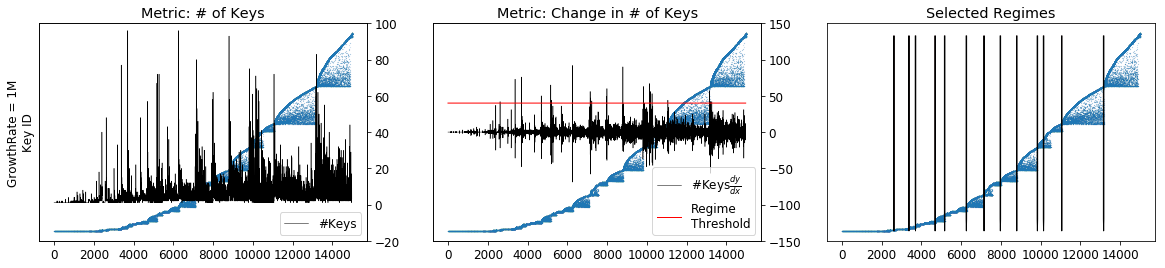

In [4]:
props = dict(facecolor='red', width=0.5, headwidth=0.5) # line properties
def AD_derivative(ax, dfs, key_tuple, keyheight=(10, 50000)):
    d = dfs[key_tuple]['DF_KEY_TIMES']                # get the count df for this run
    d = d.drop_duplicates()                           # drop duplicates
    ts = int(d['ts'].head(1))                         # first timestep
    d['shift'] = d['ts'] - ts * np.ones(len(d['ts'])) # shift timestamps        
    d = d.groupby('shift').size().reset_index()       # unique keys over time
    d.columns=['shift', 'count']

    last_regime_countdown = 120
    dy = np.diff(d['count'])/1                       # take the derivative
    for i in range(0, len(dy)):                       # if derivative is greater than some threshold
        if dy[i] > 40 and last_regime_countdown <=0:
            ax.annotate("", xy=(i, keyheight[0]), xytext=(i, keyheight[1]), arrowprops=props, ha="center")
            last_regime_countdown = 120
        if last_regime_countdown > 0:
            last_regime_countdown -= 1
    return d['count'], dy
            
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
run = ("4 Node, 1M", "DBMemoryGet", "4")

ax[2].set_title(r'Selected Regimes')
plot_keyspace(ax[2], dfs, run)
y, dy = AD_derivative(ax[2], dfs, run)
ax[2].set_ylabel("")

ax[0].set_title(r'Metric: # of Keys')    
plot_keyspace(ax[0], dfs, run)
ax2 = ax[0].twinx()
ax2.plot(range(0, len(y)), y, color='black', lw=0.5, label=r'#Keys')
ax2.legend(loc='lower right')
ax2.set_ylim(-20, 100)
ax[0].set_ylabel("GrowthRate = 1M\nKey ID")

ax[1].set_title(r'Metric: Change in # of Keys')    
plot_keyspace(ax[1], dfs, run)
ax2 = ax[1].twinx()
ax2.plot(range(0, len(dy)), dy, color='black', lw=0.5, label=r'#Keys$\frac{dy}{dx}$')
ax2.plot(range(0, len(dy)), 40*np.ones(len(dy)), color='red', lw=1, label="Regime\nThreshold")
ax2.legend(loc='lower right')
ax2.set_ylim(-150, 150)
x = ax[1].set_ylabel("")

For the 3 graphs above, we found an access regime detector that works:
- **Metric: # of Keys**:  instantaneous number of keys (*y2* axis) doesn't signal a regime change; there is not a clear threshold or patterns
- **Metric: Change in # of Keys**: large positive spikes is an injection of many keys
- **Selected Regimes**: using a "slope-change-threshold" of 40 and a "back-off-window"* of 200 seems to work!

*"back-off window": don't change regimes too often within this window

To check the generality of this model, we run against a growth rate of 100K:

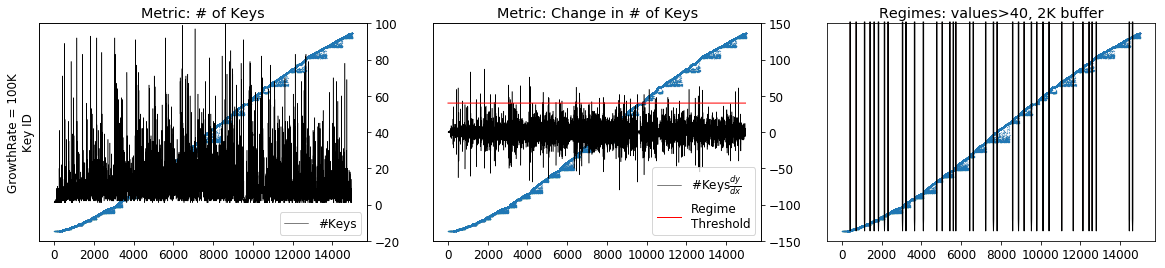

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
run = ("4 Node, 100K", "DBMemoryGet", "4")

ax[2].set_title(r'Regimes: values>40, 2K buffer')
plot_keyspace(ax[2], dfs, run)
y, dy = AD_derivative(ax[2], dfs, run, keyheight=(10, 170000))
ax[2].set_ylabel("")

ax[0].set_title(r'Metric: # of Keys')    
plot_keyspace(ax[0], dfs, run)
ax2 = ax[0].twinx()
ax2.plot(range(0, len(y)), y, color='black', lw=0.5, label=r'#Keys')
ax2.legend(loc='lower right')
ax2.set_ylim(-20, 100)
ax[0].set_ylabel("GrowthRate = 100K\nKey ID")

ax[1].set_title(r'Metric: Change in # of Keys')    
plot_keyspace(ax[1], dfs, run)
ax2 = ax[1].twinx()
ax2.plot(range(0, len(dy)), dy, color='black', lw=0.5, label=r'#Keys$\frac{dy}{dx}$')
ax2.plot(range(0, len(dy)), 40*np.ones(len(dy)), color='red', lw=1, label="Regime\nThreshold")
ax2.legend(loc='lower right')
ax2.set_ylim(-150, 150)
x = ax[1].set_ylabel("")

Why didn't this work? Because we hard-coded a bunch of parameters:
- "slope-change-threshold" = 40
- "back-off-window" = 200
- instantaneous keyspace size (the metric we used) is not accurate of entire "fan" access regime

## Less Basic Way: Moving Average, Zero-Crossings, 
We can get a more accurate view of the current keyspace by putting a decay (or countdown) on each key to capture this "fan" behaviour. We maintain a dictionary of the active keys and at every timestep, we decay the key until it reaches 0. 0-valued keys are evicted. By maintaining this keyspace on our own we can look at more metrics:
- **# of Active Keys**: size of the keyspace
- **# of Deleted Keys**: keys expiring in that timestep

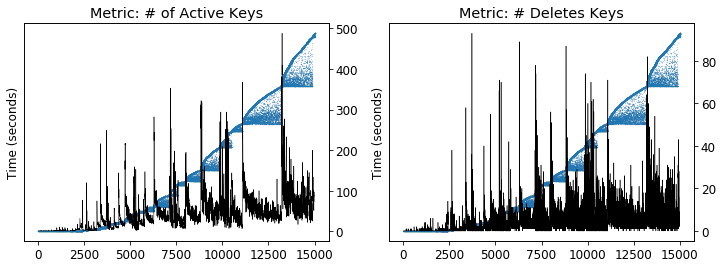

In [6]:
props = dict(facecolor='black', width=0.5, headwidth=0.5) # line properties

def AD_get_metric(input, decay=10):
    active   = {} # ID -> decay count
    INIT     = decay # seconds before we consider a key old
    history  = [] # history of unique keyes
    delhist  = []
    stateIDs = {} # key -> ID
    stateID  = 1  # name of current key
    uniquets = len(input['shift'].drop_duplicates())
    for i in range(0, uniquets):          # simulate, as if we are seeing events online
        d = input[input['shift'] == i]         # create dataframe of events we have seen up to this point
        
        for k, v in active.iteritems():        # update our vision of the cache
            active[k] = v - 1
        
        for _, e in d.iterrows():              # get stats for current timestep
            k = e['key']
            if k not in stateIDs:              # have we seen this state before
                stateIDs[k] = stateID
                stateID += 1
            active[stateIDs[k]] = INIT         # if it doesn't exist, set 10, if it does reset it

        deleteme = []
        for k, v in active.iteritems():        # evict old keys
            if v <= 0:
                deleteme.append(k)
        
        for k in deleteme:
            del active[k]
        history.append(len(active)) 
        delhist.append(len(deleteme)) 
    return history, delhist

def AD_derivative_v1(ax, dfs, key_tuple, decay=10):
    input = dfs[key_tuple]['DF_KEY_TIMES']            # get the count df for this run
    input = input.drop_duplicates()                   # drop duplicates
    ts = int(input['ts'].head(1))                     # first timestep
    shift =  ts * np.ones(len(input['ts']))           # create array of initial timestamp
    input['shift'] = input['ts'] - shift              # shift timestamps
    input = input.drop_duplicates()

    history, delhist = AD_get_metric(input, decay)
    return history, delhist
    
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
run = ("4 Node, 1M", "DBMemoryGet", "4")
history, delhist = AD_derivative_v1(ax[0], dfs, run, decay=10)

ax[0].set_title(r'Metric: # of Active Keys')    
plot_keyspace(ax[0], dfs, run)
ax[0].twinx().plot(range(0, len(history)), history, color='black', lw=0.5)

ax[1].set_title(r'Metric: # Deletes Keys')    
plot_keyspace(ax[1], dfs, run)
x = ax[1].twinx().plot(range(0, len(delhist)), delhist, color='black', lw=0.5)

Neither of these work particularly well because, again, there is no clear threshold. We apply a moving average to reduce the noise, take the derivative to strip away magnitudes, and notice that access regime changes are signaled with a large positive slope (high magnitude above *x* axis) followed by a large negative slope. We calculate the largest zero-crossings and get:

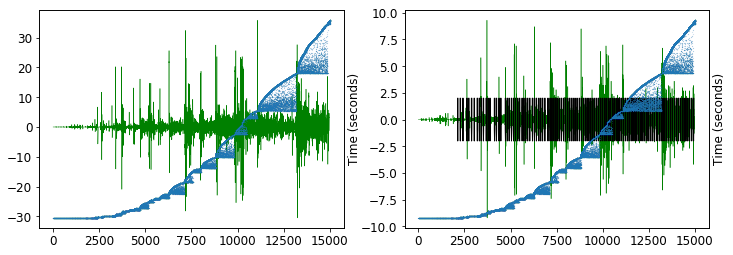

In [7]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')
activeKdy = movingaverage(np.diff(history)/1, 10)
deleteKdy = movingaverage(np.diff(delhist)/1, 10)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_keyspace(ax[0].twinx(), dfs, run)
ax[0].plot(range(0, len(activeKdy)), activeKdy, lw=0.5, color='green')
plot_keyspace(ax[1].twinx(), dfs, run)
ax[1].plot(range(0, len(deleteKdy)), deleteKdy, lw=0.5, color='green')

WAIT = 100
trig = WAIT
BIG = 0 # I saw a positive spike within the last 10 seconds
for i in range(0, len(activeKdy)):
    if BIG > 0:
        BIG -= 1
    if activeKdy[i] > 1:
        BIG = WAIT
    if activeKdy[i] < -1 and BIG > 0 and trig <= 0:
        ax[1].annotate("", xy=(i, -2), xytext=(i, 2), arrowprops=props, ha="center")
        trig = WAIT
        
    if trig > 0:
        trig -= 1
        
#ax[1].plot(range(0, len(activeKdy)), 0*np.ones(len(activeKdy)), color='red')
#for x in range(0, len(ax)):
#    ax[x].set_xlim(13100, 14000)

We still have the same problem: we don't know what the parameters to use for:
- "slope-change-threshold"
- "back-off-window"

Plus, we have now introduced hard-coded parameters for:
- **history of keyspace**: decay for key eviction (10 seconds)
- **zero-crossing**: decay for small spike after big spike (10 seconds)
- **moving average**: window size (10 seconds)


... if I were to continue down this path, I bet it still wouldn't work for 100K

## Abandon Statistical Anomaly Detection
- need to hard code derivative threshold for anomalies
- does not work for growth rate 100K
- more accurate metrics that capture entire fan do not accurately detect